This is going to randomly sample, but then also return consective data points. both based on a dim

In [1]:
import torch
from torch.utils.data import Dataset, Sampler, DataLoader
import numpy as np
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class WaveformDataset(Dataset):
    def __init__(self, wav_data, t_input):
        self.wav_data = wav_data
        self.time_steps = t_input
        self.length = len(wav_data)

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        return self.wav_data[idx], self.time_steps[idx]

In [3]:
class RandomConsecutiveSampler(Sampler):
    def __init__(self, data_source, batch_size, consecutive_size):
        self.data_source = data_source
        self.batch_size = batch_size
        self.consecutive_size = consecutive_size

    def __iter__(self):
        indices = np.random.permutation(len(self.data_source) - self.consecutive_size + 1)
        for i in range(0, len(indices), self.batch_size):
            batch_indices = []
            for j in range(i, min(i + self.batch_size, len(indices))):
                start_idx = indices[j]
                batch_indices.extend(range(start_idx, start_idx + self.consecutive_size))
            yield batch_indices

    def __len__(self):
        return (len(self.data_source) - self.consecutive_size ) // self.batch_size


    
    

wav_data = np.linspace(1,100,100).tolist()  # Example waveform data
t_input = np.linspace(1,100,100).tolist()  # Example time step data

dataset = WaveformDataset(wav_data, t_input)
batch_size = 17
consecutive_size = 13

sampler = RandomConsecutiveSampler(dataset, batch_size, consecutive_size)
data_loader = DataLoader(dataset, batch_sampler=sampler)



In [4]:
def consecutive_dif(prediction, target, consecutive_size):
    """
    This will calculate the differences across consecutive points.  
    use RandomConsecutiveSampler for intended results
    """
    pred_reshape = prediction.view(-1,consecutive_size)
    target_reshape = target.view(-1,consecutive_size)
    pred_dif = pred_reshape[:,1:] - pred_reshape[:,:-1]
    target_dif = target_reshape[:,1:] - target_reshape[:,:-1]
    return torch.mean((pred_dif - target_dif)**2)

    
class ConsecutiveDifferenceLoss(nn.Module):
    def __init__(self, consecutive_size):
        super(ConsecutiveDifferenceLoss, self).__init__()
        self.consecutive_size = consecutive_size

    def forward(self, prediction, target):
        pred_reshape = prediction.view(-1, self.consecutive_size)
        target_reshape = target.view(-1, self.consecutive_size)
        pred_dif = pred_reshape[:, 1:] - pred_reshape[:, :-1]
        target_dif = target_reshape[:, 1:] - target_reshape[:, :-1]
        return torch.mean((pred_dif - target_dif) ** 2)
    
    
class ConsecutiveDifferenceHigherOrderLoss(nn.Module):
    def __init__(self, consecutive_size,order=1):
        super(ConsecutiveDifferenceHigherOrderLoss, self).__init__()
        self.consecutive_size = consecutive_size

    def forward(self, prediction, target):
        pred_reshape = prediction.view(-1, self.consecutive_size)
        target_reshape = target.view(-1, self.consecutive_size)
        pred_dif = pred_reshape[:, 1:] - pred_reshape[:, :-1]
        target_dif = target_reshape[:, 1:] - target_reshape[:, :-1]
        return torch.mean((pred_dif - target_dif) ** 2)

   
# variations.  you can do the differences with all the other consecutive points.  
# you could do differences along the batch.  those are consecutive points but they shift one each time
# weight those with the dif in t.  that could be interesting.  
#might add in another dataloader? a completely random one? what if you use mse on the random one? 
#thats interesting.  or maybe just weird.  
#no its interesting.  you learn the slopes from differences, then the vertical shift from mse on different points.  
# try these on a single wave to learn frequency.  then add in phi?

class ConsecutiveDifferenceLossAndBatch(nn.Module):
    def __init__(self, consecutive_size):
        super(ConsecutiveDifferenceLossAndBatch, self).__init__()
        """
        This does the consecutive loss as well as the batch loss.  
        This does look consecutively differences across batches, i wonder how that will effect it.  
        
        """
        self.consecutive_size = consecutive_size

    def forward(self, prediction, target):
        pred_reshape = prediction.view(-1, self.consecutive_size)
        target_reshape = target.view(-1, self.consecutive_size)
        pred_dif = pred_reshape[:, 1:] - pred_reshape[:, :-1]
        target_dif = target_reshape[:, 1:] - target_reshape[:, :-1]
        
        pred_dif_batch = pred_reshape[1:, :] - pred_reshape[:-1, :]
        target_dif_batch = target_reshape[1:, :] - target_reshape[:-1, :]
        
        consec_loss = torch.mean((pred_dif - target_dif) ** 2)
        batch_loss = torch.mean((pred_dif_batch - target_dif_batch) ** 2)
        
        return consec_loss + batch_loss

    
class ConsecutiveSlopeWeightedMSELoss(nn.Module):
    def __init__(self, consecutive_size):
        super(ConsecutiveSlopeWeightedMSELoss, self).__init__()
        """this is just mse weighted by how different the slope before and after the point is"""
        self.consecutive_size = consecutive_size

    def forward(self, prediction, target):
        pred_reshape = prediction.view(-1, self.consecutive_size)
        target_reshape = target.view(-1, self.consecutive_size)
        #pred_dif = pred_reshape[:, 1:] - pred_reshape[:, :-1]
        target_slope = target_reshape[:, 1:] - target_reshape[:, :-1]
        
        target_slope_dif = target_slope[:, 1:] - target_slope[:, :-1]
        
        
        errors = pred_reshape[:,1:-1] - target_reshape[:,1:-1]
        
        return torch.mean(target_slope_dif **2 * errors **2)

class ConsecutiveDifferenceHigherOrderLoss(nn.Module):
    def __init__(self, consecutive_size,order=1):
        super(ConsecutiveDifferenceHigherOrderLoss, self).__init__()
        self.consecutive_size = consecutive_size
        self.order = order
    def forward(self, prediction, target):
        pred_reshape = prediction.view(-1, self.consecutive_size)
        target_reshape = target.view(-1, self.consecutive_size)
        result = torch.tensor([0.0])
        
        pred_a = pred_reshape[:, 1:]
        pred_b = pred_reshape[:, :-1]
        target_a = target_reshape[:, 1:]
        target_b = target_reshape[:, :-1]
        for i in range(self.order):
            
            pred_dif = pred_a - pred_b
            target_dif = target_a - target_b
            pred_a = pred_dif[:, 1:]
            pred_b = pred_dif[:, :-1]
            target_a = target_dif[:, 1:]
            target_b = target_dif[:, :-1]
            
            result +=  torch.mean((pred_dif - target_dif) ** 2)/self.order
        return result

    
class ConsecutiveDifferenceHigherOrderLossBatch(nn.Module):
    def __init__(self, consecutive_size,order=1):
        super(ConsecutiveDifferenceHigherOrderLossBatch, self).__init__()
        self.consecutive_size = consecutive_size
        self.order = order
    def forward(self, prediction, target):
        pred_reshape = prediction.view(-1, self.consecutive_size)
        target_reshape = target.view(-1, self.consecutive_size)
        result = torch.tensor([0.0])
        
        pred_a = pred_reshape[ 1:, :]
        pred_b = pred_reshape[:-1,:]
        target_a = target_reshape[ 1:, :]
        target_b = target_reshape[:-1,:]
        for i in range(self.order):
            
            pred_dif = pred_a - pred_b
            target_dif = target_a - target_b
            pred_a = pred_dif[ 1:, :]
            pred_b = pred_dif[:-1,:]
            target_a = target_dif[ 1:, :]
            target_b = target_dif[:-1,:]
            
            result +=  torch.mean((pred_dif - target_dif) ** 2)/self.order
        return result
    
class WeightedMSELoss(nn.Module):
    def __init__(self,max_amp = 142.76):
        super(WeightedMSELoss, self).__init__()
        self.max_amp = max_amp
        
    def forward(self, predictions, targets):
        assert predictions.size() == targets.size(), "Size mismatch between predictions and targets"
        
        target_weights = (targets/self.max_amp) ** 2
        squared_error = (predictions - targets) ** 2
        
        weighted_error = target_weights * squared_error
        
        loss = torch.mean(weighted_error)
        return loss

In [132]:
class WeirdSinLayer(nn.Module):
    def __init__(self):
        super(WeirdSinLayer, self).__init__()
        
        self.param_A = nn.Parameter(torch.randn(1, 3))  # Amplitude
        #self.param_f = nn.Parameter(torch.randn(1, 3))  # Frequency
        self.param_phi = nn.Parameter(torch.randn(1, 3))  # Phase shift
        self.param_C = nn.Parameter(torch.randn(1, 3))  # Vertical shift

    def forward(self, t):
        if t.dim() == 1:
            t = t.unsqueeze(-1)  #may not be necessary, i forget how my dataloader do it
        
        #out_params = self.param_A * torch.sin(self.param_f * t + self.param_phi) + self.param_C
        out_params = self.param_A * torch.sin( t + self.param_phi) + self.param_C
        
        out_A = out_params[:, 0].unsqueeze(-1)  
        out_phi = out_params[:, 1].unsqueeze(-1)      
        out_C = out_params[:, 2].unsqueeze(-1) 
        
        out_t = out_A * torch.sin(t + out_phi) + out_C
        
        return out_t
    
class WeirdSinNetwork(nn.Module):
    def __init__(self, num_layers):
        super(WeirdSinNetwork, self).__init__()
        
        # Dynamically create the specified number of WeirdSinLayer layers
        self.layers = nn.ModuleList([WeirdSinLayer() for _ in range(num_layers)])

    def forward(self, t):
        # Pass the input through each layer in sequence
        for layer in self.layers:
            t = layer(t)
        return t
    
class WeirdSinNetworkInc(nn.Module):
    def __init__(self, num_layers,inc=0.1):
        super(WeirdSinNetworkInc, self).__init__()
        
        # Dynamically create the specified number of WeirdSinLayer layers
        self.layers = nn.ModuleList([WeirdSinLayer() for _ in range(num_layers)])
        for idx,layer in enumerate(self.layers):
            print(layer.param_A)
            additive = torch.tensor([idx*inc]).unsqueeze(-1).float()
            layer.param_A = nn.Parameter(layer.param_A + additive)
            print(layer.param_A)

    def forward(self, t):
        # Pass the input through each layer in sequence
        for layer in self.layers:
            t = layer(t)
        return t

In [49]:
def generate_gaussian_noise(outputs, mean=0, std_dev=1):


    
    # Get the shape of the outputs
    shape = outputs.shape
    
    
    # Generate Gaussian noise with the same shape as the outputs
    noise = torch.normal(mean=mean, std=std_dev, size=shape)
    
    return noise

Sample Rate: 24000
Data Shape: (14400,)


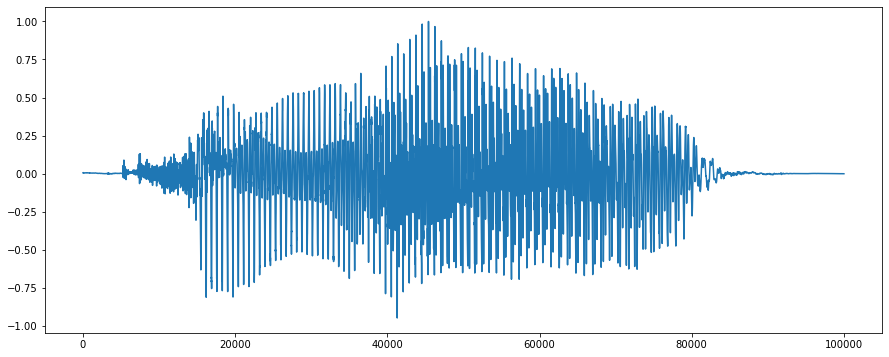

In [182]:
import numpy as np
from scipy.io import wavfile

# Load the WAV file
file_path = 'hello.wav'
sample_rate, data = wavfile.read(file_path)

# Print out the sample rate and the shape of the numpy array
print("Sample Rate:", sample_rate)
print("Data Shape:", data.shape)
data_t = torch.from_numpy(np.linspace(1,100_000,data.shape[0]))
max_amp = max(abs(data))
data= data/max_amp
##data = data.detach().numpy().astype(np.float64)
plt.figure(figsize=(15, 6))

plt.plot(data_t, data, label='Layer Output')



In [133]:
data = generate_gaussian_noise(data, mean=0, std_dev=1)

In [183]:
dataset = WaveformDataset(data, data_t)
batch_size = 100
consecutive_size = 20

sampler = RandomConsecutiveSampler(dataset, batch_size, consecutive_size)
data_loader = DataLoader(dataset, batch_sampler=sampler)

In [166]:
num_layers = 10 # Let's say we want 5 layers in the network
model = WeirdSinNetworkInc(num_layers)

Parameter containing:
tensor([[-0.2786,  0.4999,  0.1220]], requires_grad=True)
Parameter containing:
tensor([[-0.2786,  0.4999,  0.1220]], requires_grad=True)
Parameter containing:
tensor([[-0.3894, -1.4426,  0.1947]], requires_grad=True)
Parameter containing:
tensor([[ 0.6106, -0.4426,  1.1947]], requires_grad=True)
Parameter containing:
tensor([[0.0651, 0.3384, 0.0464]], requires_grad=True)
Parameter containing:
tensor([[2.0651, 2.3384, 2.0464]], requires_grad=True)
Parameter containing:
tensor([[ 0.6185, -0.2443, -1.2631]], requires_grad=True)
Parameter containing:
tensor([[3.6185, 2.7557, 1.7369]], requires_grad=True)
Parameter containing:
tensor([[ 0.3717,  0.2891, -0.9255]], requires_grad=True)
Parameter containing:
tensor([[4.3717, 4.2891, 3.0745]], requires_grad=True)
Parameter containing:
tensor([[-0.7331,  1.7400,  0.5718]], requires_grad=True)
Parameter containing:
tensor([[4.2669, 6.7400, 5.5718]], requires_grad=True)
Parameter containing:
tensor([[-1.7577,  0.5701, -1.229

In [212]:
import torch
import torch.nn as nn
import torch.optim as optim

# Assuming you have defined your model, loss function, and optimizer
# Example:
# model = YourModel()
cdifb_loss = ConsecutiveDifferenceHigherOrderLossBatch(consecutive_size,order=3)
cdif_loss = ConsecutiveDifferenceHigherOrderLoss(consecutive_size,order=3)
#ConsecutiveDifferenceLoss(consecutive_size)  #ConsecutiveDifferenceLossAndBatch(consecutive_size) #  consecutive_dif(prediction, target, consecutive_size)
mse_loss = WeightedMSELoss(max_amp) #nn.MSELoss() #ConsecutiveSlopeWeightedMSELoss(consecutive_size) #
optimizer = optim.Adam(model.parameters(), lr=0.00003)

# Training loop
num_epochs = 20  # Set the number of epochs
model.train()  # Set the model to training mode

for epoch in range(num_epochs):
    running_loss = 0.0
    for batch_idx, ( targets,inputs) in enumerate(data_loader):
        # Move data to the appropriate device (GPU/CPU)
        #inputs, targets = inputs.to(device), targets.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        mse = mse_loss(outputs, targets.unsqueeze(-1))
        cdif = cdif_loss(outputs, targets)
        cdif_b = cdifb_loss(outputs, targets)
        loss =    0.6*cdif + 0.2*cdif_b + 0.5 * mse

        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
    
    if epoch % 5 == 4:  # Print every 10 mini-batches
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / 10:.4f}')
    running_loss = 0.0
        
print('Training finished.')


Epoch [5/20], Loss: 361.0851
Epoch [10/20], Loss: 361.5719
Epoch [15/20], Loss: 361.3055
Epoch [20/20], Loss: 352.7794
Training finished.


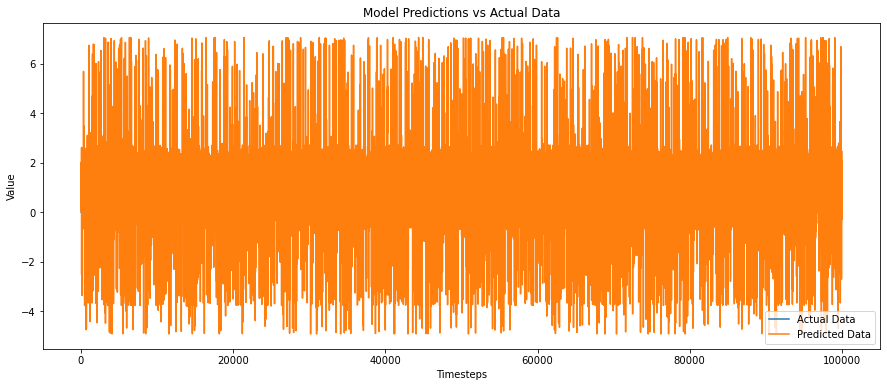

In [213]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Set the model to evaluation mode
model.eval()

# Assuming data contains the targets and data_t contains the input timesteps
data_loader_eval = DataLoader(WaveformDataset(data, data_t), batch_size=50, shuffle=False)

with torch.no_grad():
    predictions = []
    actuals = []
    timesteps = []
    for  batch_data,batch_t in data_loader_eval:
        #batch_t, batch_data = batch_t.to(device), batch_data.to(device)
        outputs = model(batch_t)
        predictions.append(outputs.cpu().numpy())
        actuals.append(batch_data.cpu().numpy())
        timesteps.append(batch_t.cpu().numpy())

# Convert lists to numpy arrays
predictions = np.concatenate(predictions, axis=0)
actuals = np.concatenate(actuals, axis=0)
timesteps = np.concatenate(timesteps, axis=0)

# Plot the results
plt.figure(figsize=(15, 6))
plt.plot( timesteps.flatten(),actuals.flatten(), label='Actual Data')
plt.plot( timesteps.flatten(),predictions.flatten(), label='Predicted Data')
plt.legend()
plt.xlabel('Timesteps')
plt.ylabel('Value')
plt.title('Model Predictions vs Actual Data')
plt.show()
